In [2]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")


%cd './drive/My Drive/Projekt/FashionMnist'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Projekt/FashionMnist


Probowałem odtworzyć drugi z modeli z tabelki w repo FashionMnist (ten z Tensorflow doc).

Architektura sieci wygląda tak samo jak tam. Nie jestem pewien co do optymalizatora, ale są na pewno bardzo podobne. Batch size był ustawiony na 200 (sporo, nie wiem czemu); ja użyłem 4.

In [67]:
#Importy i sprawdzenie czy mamy CUDA
import torch
import torchvision

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
dev

'cuda:0'

In [0]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

#katalog, w którym przechowujemy dane
root = "data"
batch_size = 4

#transformacje wektorów wejściowych
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

train_dataset = dsets.FashionMNIST(root=root,
                            train=True,
                            transform=transform,
                            download=True)

test_dataset = dsets.FashionMNIST(root=root,
                            train=False,
                            transform=transform)

trainloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=batch_size,
                                                shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=True) 

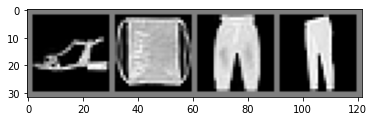

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))

In [0]:
import torch.nn as nn
import torch.nn.functional as F


#architektura sieci
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 1024)
        self.fc2 = nn.Linear(1024, 130)
        self.drop = nn.Dropout(0.4) #prawdopodobieństwo 0.6 że element zostaje

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64)
        x = self.drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


net = Net()


In [0]:
#jeżeli można, używamy CUDA
if torch.cuda.is_available():
  net.to("cuda:0")

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
def accuracy(model, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          if torch.cuda.is_available():
            images = images.to("cuda:0")
            labels = labels.to("cuda:0")

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [88]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
          inputs = inputs.to("cuda:0")
          labels = labels.to("cuda:0")


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f train accuracy: %d %%' %
                  (epoch + 1, i + 1, 
                   running_loss / 2000, 
                   accuracy(net, trainloader)))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 0.950 train accuracy: 79 %
[1,  4000] loss: 0.533 train accuracy: 83 %
[1,  6000] loss: 0.448 train accuracy: 85 %
[1,  8000] loss: 0.407 train accuracy: 85 %
[1, 10000] loss: 0.382 train accuracy: 86 %
[1, 12000] loss: 0.364 train accuracy: 87 %
[1, 14000] loss: 0.364 train accuracy: 89 %
[2,  2000] loss: 0.305 train accuracy: 88 %
[2,  4000] loss: 0.304 train accuracy: 89 %
[2,  6000] loss: 0.310 train accuracy: 89 %
[2,  8000] loss: 0.299 train accuracy: 90 %
[2, 10000] loss: 0.309 train accuracy: 90 %


KeyboardInterrupt: ignored

In [89]:
print('Accuracy of the network on test images: %d %%' % (
    accuracy(net, testloader)))

Accuracy of the network on test images: 88 %
